<a href="https://colab.research.google.com/github/mmeierer/MLP---TensorFlow-vs-PyTorch/blob/main/mlp_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification using an MLP with PyTorch

## 1. Import & Processing

### a) Importing modules

In [35]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

### b) Importing data

In [36]:
train_data = pd.read_csv('https://github.com/mmeierer/MLP---TensorFlow-vs-PyTorch/raw/main/train.csv')
test_data = pd.read_csv('https://github.com/mmeierer/MLP---TensorFlow-vs-PyTorch/raw/main/test.csv')

In [37]:
train_data.head()

,CustomerId,Churned,FrequentBuyerClass,Sex,Age,NrSiblingsSpouses,NrParentsChildren
0,1,0,3,male,22.0,1,0
1,2,1,1,female,38.0,1,0
2,3,1,3,female,26.0,0,0
3,4,1,1,female,35.0,1,0
4,5,0,3,male,35.0,0,0


In [38]:
test_data.head()

,CustomerId,FrequentBuyerClass,Sex,Age,NrSiblingsSpouses,NrParentsChildren
0,892,3,male,34.5,0,0
1,893,3,female,47.0,1,0
2,894,2,male,62.0,0,0
3,895,3,male,27.0,0,0
4,896,3,female,22.0,1,1


### c) Data preparation

In [39]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)
    return data

In [40]:
train_data = train_data[train_data.columns[-6:]]
test_data = test_data[test_data.columns[-5:]]

In [41]:
dummy_columns = ["FrequentBuyerClass"]
train_data=dummy_data(train_data, dummy_columns)
test_data=dummy_data(test_data, dummy_columns)
train_data.head()

,Churned,Sex,Age,NrSiblingsSpouses,NrParentsChildren,FrequentBuyerClass_1,FrequentBuyerClass_2,FrequentBuyerClass_3
0,0,male,22.0,1,0,0,0,1
1,1,female,38.0,1,0,1,0,0
2,1,female,26.0,0,0,0,0,1
3,1,female,35.0,1,0,1,0,0
4,0,male,35.0,0,0,0,0,1


In [42]:
def sex_to_int(data):
    le = LabelEncoder()
    le.fit(["male","female"])
    data["Sex"]=le.transform(data["Sex"]) 
    return data

train_data = sex_to_int(train_data)
test_data = sex_to_int(test_data)
train_data.head()

,Churned,Sex,Age,NrSiblingsSpouses,NrParentsChildren,FrequentBuyerClass_1,FrequentBuyerClass_2,FrequentBuyerClass_3
0,0,1,22.0,1,0,0,0,1
1,1,0,38.0,1,0,1,0,0
2,1,0,26.0,0,0,0,0,1
3,1,0,35.0,1,0,1,0,0
4,0,1,35.0,0,0,0,0,1


In [43]:
def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data
    
train_data = normalize_age(train_data)
test_data = normalize_age(test_data)
train_data.head()

,Churned,Sex,Age,NrSiblingsSpouses,NrParentsChildren,FrequentBuyerClass_1,FrequentBuyerClass_2,FrequentBuyerClass_3
0,0,1,0.271174,1,0,0,0,1
1,1,0,0.472229,1,0,1,0,0
2,1,0,0.321438,0,0,0,0,1
3,1,0,0.434531,1,0,1,0,0
4,0,1,0.434531,0,0,0,0,1


In [44]:
train_data.Age.fillna(train_data.Age.median(),inplace=True)
test_data.Age.fillna(test_data.Age.median(),inplace=True)

In [45]:
def split_valid_test_data(data, fraction=(0.2)):
    y_data = data["Churned"]

    x_data = data.drop(["Churned"], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=fraction)

    return x_train.values, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_valid_test_data(train_data)
print("x_train:{}, {}".format(x_train.shape, type(x_train)))
print("y_train:{}, {}".format(y_train.shape, type(y_train)))

print("x_test:{}, {}".format(x_test.shape, type(x_test)))
print("y_test:{}, {}".format(y_test.shape, type(y_test)))

x_train:(712, 7), <class 'numpy.ndarray'>
y_train:(712,), <class 'pandas.core.series.Series'>
x_test:(179, 7), <class 'pandas.core.frame.DataFrame'>
y_test:(179,), <class 'pandas.core.series.Series'>


In [46]:
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

## 2. Model specific data preparation

### a) Load the data

In [47]:
x_train_pt = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test_pt = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train_pt = torch.from_numpy(y_train).type(torch.FloatTensor)
y_test_pt = torch.from_numpy(y_test).type(torch.FloatTensor)

### b) Tensor view of the data

In [48]:
x_train_pt[0]

tensor([0.0000, 0.3591, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000])

In [49]:
y_train_pt[0]

tensor(1.)

## 3. Model definition

### a) Sequentially add layers

In [50]:
def weights_init(m):
  if isinstance(m, nn.Linear):
      nn.init.uniform_(m.weight.data, -1,1)
      nn.init.zeros_(m.bias.data)

In [51]:
model_pt = nn.Sequential(nn.Linear(x_train.shape[1], 16),
                      nn.ReLU(),
                      nn.Linear(16, 32),
                      nn.ReLU(),
                      nn.Linear(32, 1),
                      nn.Sigmoid())

In [52]:
model_pt.apply(weights_init)

Sequential(
  (0): Linear(in_features=7, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)

### b) Inspect the model

In [53]:
print(model_pt)

Sequential(
  (0): Linear(in_features=7, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)


### c) Inspect the first hidden layer

In [54]:
model_pt[0].weight[0]

tensor([ 0.3003, -0.2422,  0.9694, -0.1363, -0.8043,  0.6678, -0.1085],
       grad_fn=<SelectBackward>)

In [55]:
model_pt[0].weight.shape

torch.Size([16, 7])

In [56]:
model_pt[0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [57]:
model_pt[0].bias.shape

torch.Size([16])

## 4. Loss & Optimizer

In [58]:
optimizer_pt = optim.Adam(model_pt.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_fn_pt = nn.BCELoss()

## 5. Training

### a) Training loop

In [59]:
def get_correct(y_pred,labels):
  pred = y_pred > 0.5
  truth = labels > 0.5

  return pred.eq(truth.data).sum().item()

In [60]:
def train_step_pt(model, optimizer, loss_fn, batch_size=10):
    model.train()
    train_correct = 0
    total_loss = 0.0
    for beg_i in range(0, x_train_pt.size(0), batch_size):
        x_train_batch_pt = x_train_pt[beg_i:beg_i + batch_size]
        y_train_batch_pt = y_train_pt[beg_i:beg_i + batch_size]

        optimizer.zero_grad()
        
        y_pred_pt = model(x_train_batch_pt)

        loss = loss_fn(y_pred_pt.squeeze(), y_train_batch_pt)

        loss.backward()
        
        optimizer.step()

        train_correct += get_correct(y_pred_pt.squeeze(),y_train_batch_pt)       
        total_loss += np.sum(loss.data.numpy())
    return total_loss/x_train_pt.size(0), train_correct/x_train_pt.size(0)

In [61]:
def test_step_pt(model, optimizer, loss_fn, batch_size=10):
  test_correct = 0
  total_loss = 0.0
  for beg_i in range(0, x_test_pt.size(0), batch_size):
        x_test_batch_pt = x_test_pt[beg_i:beg_i + batch_size]
        y_test_batch_pt = y_test_pt[beg_i:beg_i + batch_size]

        y_pred_pt = model(x_test_batch_pt)

        test_correct += get_correct(y_pred_pt.squeeze(),y_test_batch_pt)

        loss = loss_fn(y_pred_pt.squeeze(),y_test_batch_pt)
        total_loss += np.sum(loss.data.numpy())
  return total_loss/x_test_pt.size(0), test_correct/x_test_pt.size(0)


In [62]:
train_loss_pt = []
test_loss_pt = []

train_acc_pt = []
test_acc_pt = []

epochs = 200
for epoch in range(epochs):
  train_loss, train_acc = train_step_pt(model_pt, optimizer_pt, loss_fn_pt)
  train_loss_pt.append(train_loss)
  train_acc_pt.append(train_acc*100)

  test_loss, test_acc = test_step_pt(model_pt, optimizer_pt, loss_fn_pt)
  test_loss_pt.append(test_loss)
  test_acc_pt.append(test_acc*100)

  template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}")
  print(template.format(epoch+1, train_loss, train_acc*100, test_loss, test_acc*100))

Epoch 1, Loss: 0.16521500783522478, Accuracy: 56.60112359550562, Test Loss: 0.07472556879400541, Test Accuracy: 69.27374301675978
Epoch 2, Loss: 0.06629235406270188, Accuracy: 70.64606741573034, Test Loss: 0.05926797027028473, Test Accuracy: 76.53631284916202
Epoch 3, Loss: 0.054303134027659225, Accuracy: 76.54494382022472, Test Loss: 0.05373977449353181, Test Accuracy: 79.3296089385475
Epoch 4, Loss: 0.05000319721156292, Accuracy: 77.80898876404494, Test Loss: 0.051194159012267045, Test Accuracy: 78.2122905027933
Epoch 5, Loss: 0.047778595050566655, Accuracy: 79.49438202247191, Test Loss: 0.04937820194819786, Test Accuracy: 77.09497206703911
Epoch 6, Loss: 0.046345520251838676, Accuracy: 80.19662921348315, Test Loss: 0.048146674253421125, Test Accuracy: 76.53631284916202
Epoch 7, Loss: 0.04538845886172873, Accuracy: 80.47752808988764, Test Loss: 0.047347595571805644, Test Accuracy: 77.6536312849162
Epoch 8, Loss: 0.044695962932002675, Accuracy: 80.6179775280899, Test Loss: 0.046701620

### b) Training progress

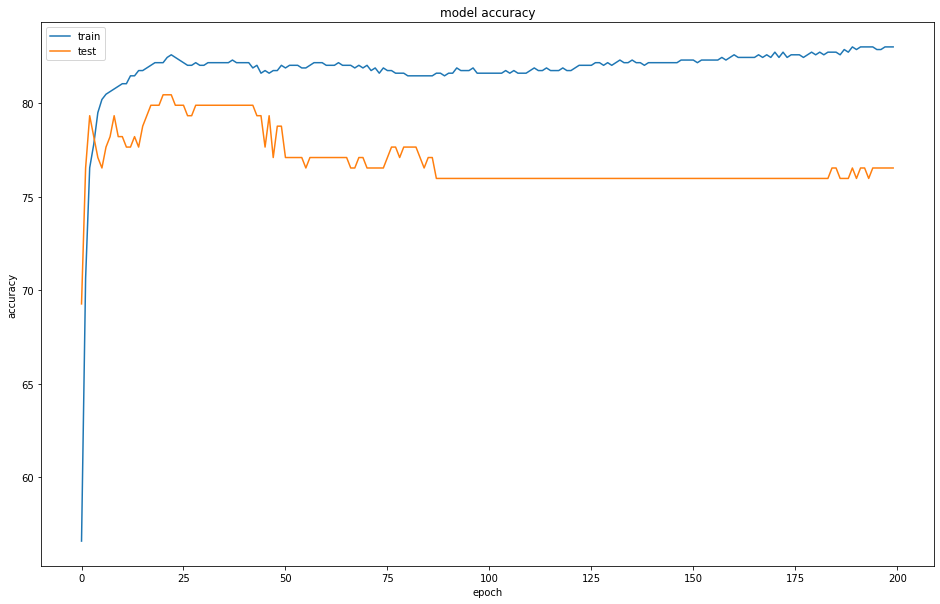

In [63]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_pt)
plt.plot(test_acc_pt)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

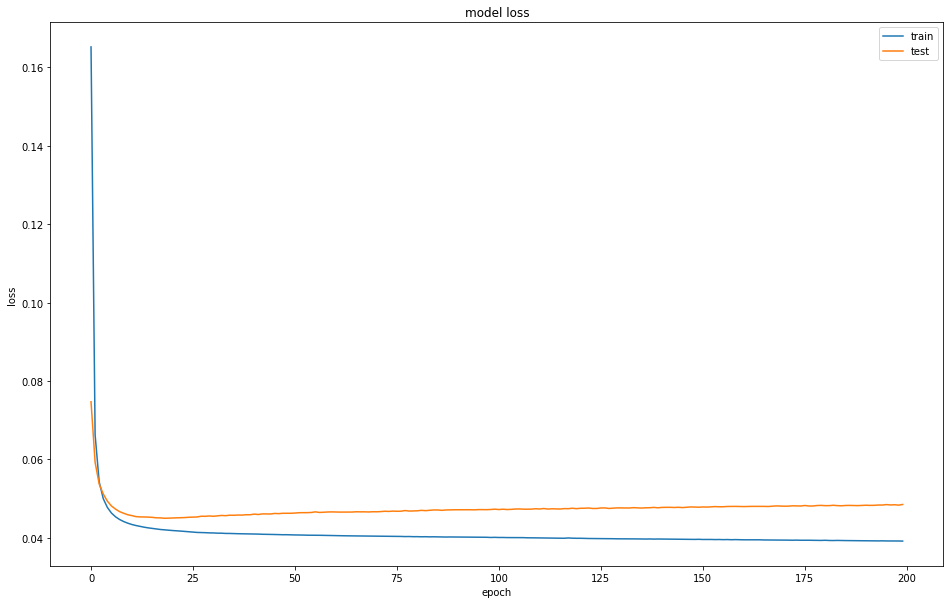

In [64]:
plt.figure(figsize=(16,10))
plt.plot(train_loss_pt)
plt.plot(test_loss_pt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

### c) Inspect the first hidden layer after training

In [65]:
model_pt[0].weight[0]

tensor([ 0.4363, -0.0776,  0.9515, -0.2618, -0.4653,  1.0156, -0.3122],
       grad_fn=<SelectBackward>)

In [66]:
model_pt[0].bias

Parameter containing:
tensor([ 5.0458e-02, -5.8894e-05, -5.6118e-02, -7.6552e-02,  1.7350e-02,
        -7.0825e-02, -1.0849e-01,  1.9064e-01,  1.1587e-01, -2.1305e-01,
         3.4815e-02,  4.7047e-02, -5.1374e-02,  4.7754e-02,  2.3674e-01,
         5.5248e-02], requires_grad=True)

## 6. Evaluation

In [67]:
y_pred = model_pt(x_test_pt) > 0.5

In [68]:
accuracy_score(y_test_pt, y_pred)

0.7653631284916201